

---

# Seagrass Analysis FR

---



In [ ]:
!pip install geemap --quiet
!pip install rasterio --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 73.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import datetime
import rasterio
from rasterio.plot import show
import zipfile
import numpy as np
from shapely.geometry import Point
from shapely.geometry import box
import zipfile
import os

In [ ]:
# prediction rasters
predicts_zip = "predicts.zip"
extract_dir = "predicts"

with zipfile.ZipFile(predicts_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [ ]:
# coastline as basemap for testing
shapefile_zip = "auckland_coastline_shapefile.zip"
coastline_gdf = gpd.read_file(f"zip://{shapefile_zip}")

dem_path = "auckland-part-1-lidar-1m-dem-2024.tif"
aoi_geom = "aoi.geojson"
aoi_gdf = gpd.read_file(aoi_geom)


In [ ]:
# turn raster to point cloud
def raster_to_points_gdf(raster_path, classes=None):

    with rasterio.open(raster_path) as src:
        data = src.read(1)
        transform = src.transform
        crs = src.crs

        if classes is None:
            classes = np.unique(data[~np.isnan(data)])

        geoms = []
        values = []
        for cls in classes:
            rows, cols = np.where(data == cls)
            xs, ys = rasterio.transform.xy(transform, rows, cols)
            geoms.extend([Point(x, y) for x, y in zip(xs, ys)])
            values.extend([cls] * len(xs))

    gdf = gpd.GeoDataFrame({'value': values, 'geometry': geoms}, crs=crs)
    gdf = gpd.clip(gdf, aoi_gdf)
    return gdf

gdf_2000 = raster_to_points_gdf('predicts/2000.tif', classes=[1, 2, 3])
gdf_2023 = raster_to_points_gdf('predicts/2023.tif', classes=[1, 2, 3])

In [ ]:
high_tide = 1.5 #NIWA tidal forecaster
low_tide = 1
light = 166/4.6 #solarviewer gives us W/m2 but we need umole.m2/s fml
kd = 0.4 #
pmax_sub = 6240 #flowers et al
a_sub = 32.4
pmax_em = 4519
a_em = 22.5

In [ ]:
#============ Creating parameters
def create_parameters(gdf):
    with rasterio.open(dem_path) as src:
        coords = [(geom.x, geom.y) for geom in gdf.geometry]
        elev = [val[0] for val in src.sample(coords)]

    gdf["elevation"] = elev
    gdf["submergence_high"] = (gdf["elevation"] < high_tide).astype(int)
    gdf["submergence_low"] = (gdf["elevation"] < low_tide).astype(int)

    gdf['depth_high'] = gdf.apply(lambda row: 0 if row['submergence_high'] == 0 else high_tide - row['elevation'], axis=1)
    gdf['depth_low'] = gdf.apply(lambda row: 0 if row['submergence_low'] == 0 else low_tide - row['elevation'], axis=1)

    gdf['light_high'] = light * np.exp(-kd * gdf['depth_high'])
    gdf['light_low'] = light * np.exp(-kd * gdf['depth_low'])
    return gdf

current_gdf = create_parameters(gdf_2023)
past_gdf = create_parameters(gdf_2000)

In [ ]:
# calculating productivity using Webb et al. (1994)
def calculate_productivity(gdf):
    gdf['productivity_high'] = np.where(
        gdf['submergence_high'] == 1,
        pmax_sub * (1 - np.exp((-a_sub * gdf['light_high']) / pmax_sub)),
        pmax_em * (1 - np.exp((-a_em * gdf['light_high']) / pmax_em))
    )
    gdf['productivity_high'] /= 1e3

    gdf['productivity_low'] = np.where(
        gdf['submergence_low'] == 1,
        pmax_sub * (1 - np.exp((-a_sub * gdf['light_low']) / pmax_sub)),
        pmax_em * (1 - np.exp((-a_em * gdf['light_low']) / pmax_em))
    )
    gdf['productivity_low'] /= 1e3

    # Sparse seagrass
    mask = gdf['value'] == 3
    gdf.loc[mask, 'productivity_high'] *= 0.5
    gdf.loc[mask, 'productivity_low'] *= 0.5

    return gdf

curent_gdf = calculate_productivity(current_gdf)
past_gdf = calculate_productivity(past_gdf)

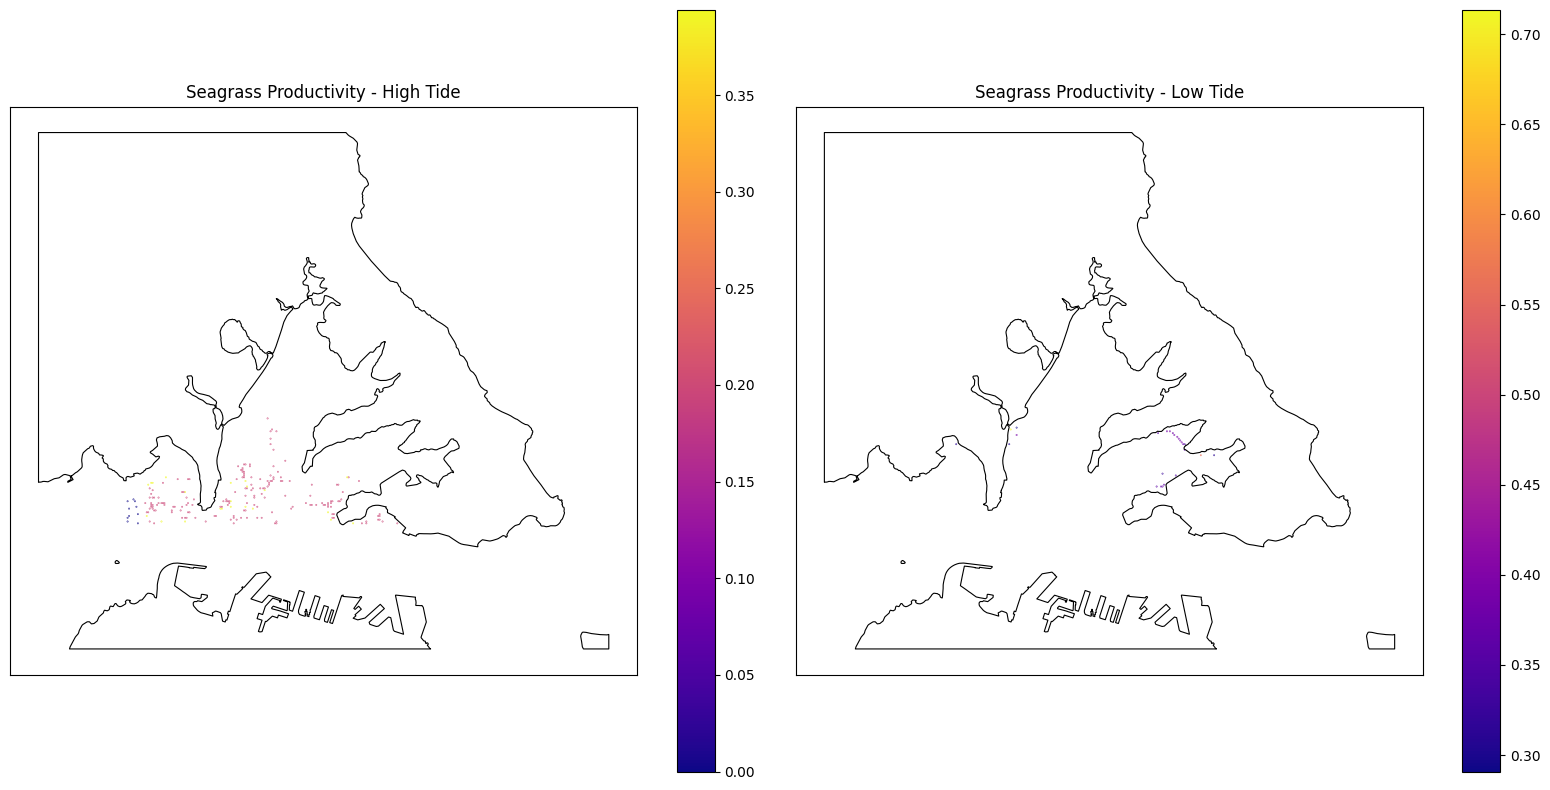

In [ ]:
# PRODUCTIVITY plots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

past_gdf.plot(column='productivity_high', cmap='plasma', legend=True, markersize=0.1, ax=axes[0])
axes[0].set_title("Seagrass Productivity - High Tide")

current_gdf.plot(column='productivity_low', cmap='plasma', legend=True, markersize=0.1, ax=axes[1])
axes[1].set_title("Seagrass Productivity - Low Tide")

# using basemap just to confirm
coastline_gdf.plot(ax=axes[0], facecolor="none", edgecolor="black", linewidth=0.8)
coastline_gdf.plot(ax=axes[1], facecolor="none", edgecolor="black", linewidth=0.8)

axes[0].set_xticks([])
axes[0].set_yticks([])
axes[1].set_xticks([])
axes[1].set_yticks([])

plt.tight_layout()
plt.show()

In [ ]:
#downloading to map on qgis
gdf = current_gdf
gdf.to_file(f"{gdf}.shp")



---

#graphs

---



In [ ]:
def harbour_wide_gpp_accumulative(gdf):
    P_high = gdf['productivity_high'].mean()
    P_low  = gdf['productivity_low'].mean()
    P_mid  = (P_high + P_low) / 2

    # Estimate total productivity (g C m⁻² day⁻¹)
    P_daily = (P_low + 4 * P_mid + P_high) / 6 * 24
    P_annual = P_daily * 365

    # Scale by total area, given 1 point represents 30x30 pixel
    total_GPP = P_annual * len(gdf)*900

    return total_GPP/1e6

GPP_2023 = harbour_wide_gpp_accumulative(current_gdf)
GPP_2000 = harbour_wide_gpp_accumulative(past_gdf)

In [ ]:
values = [GPP_2000, GPP_2023]

# Plot
fig, ax = plt.subplots(figsize=(8,8))
bars = plt.bar(['2000','2023'], values, color=['#6e7da9', '#a96e6e'])
plt.title('Total Annual Seagrass GPP (tons C)')
plt.ylabel('GPP (tons C)')
plt.xlabel('Year')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:,.0f}',
             ha='center', va='bottom', fontsize=10)

ax.set_ylabel('GPP (t C y⁻¹)')
ax.set_title('Total Annual Carbon Fixed')
plt.tight_layout()
plt.show()